In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import re
import pandas as pd
%matplotlib inline 
import numpy as np
import math
import pims
import cv2
from scipy import interpolate
from scipy.signal import savgol_filter
import skimage.filters as sk_fil
import imutils
from skimage.transform import rotate
import sys

#### For use on your setup, change following path name to appropriate choice for your environment
sys.path.insert(0, '/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/')

#### For use on your setup, change folder name (myAnalyses) to appropriate choice for your environment
import myAnalyses.lowmag_analysis_OSS as dio

/var/folders/gv/q0hyps757tjd5c_j0dwtgghc0000gq/T/ipykernel_69880/1258783473.py:196: RuntimeWarning: divide by zero encountered in divide
  inv_data = 1/accB_pos  # inverse  (in order to find minima)


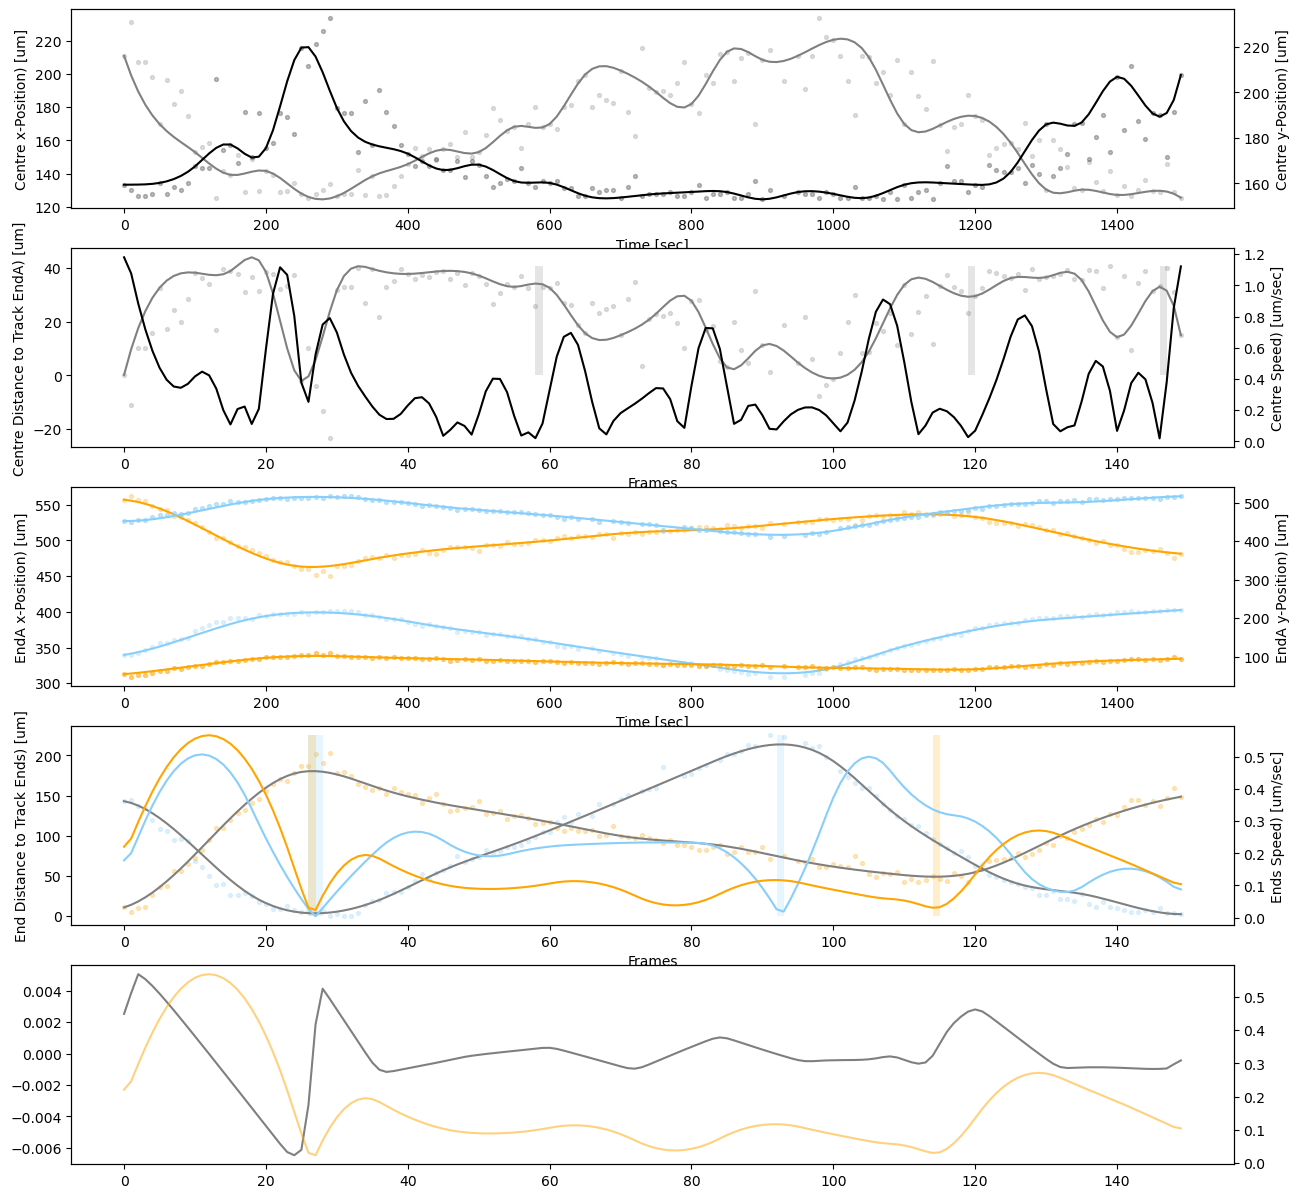

In [ ]:

###########
#GET DATA FOR ANALYSIS
###########

#### For use on your setup, change following path name to appropriate choice for your environment
path = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Results_FINAL_FINAL_agar/Results_buckling_FINAL/'
pathOut = r'/Users/lfsmbn/orkun/projects/ongoing/GBMF_motility/Results_FINAL_FINAL_agar_analysis_summary/Results_buckling_FINAL/'

#### Following example movie is provided - see Github repository. More movies available upon request
base = 'buckling_agar_x4_10sec_data'

#other file names
saveFile_image1 = pathOut+base+'_pos_speed.png'
saveFile_image2 = pathOut+base+'_dwellDistr.png'
saveMyData= pathOut+base+r'_summary_data.csv' 
saveMyData_dwell= pathOut+base+r'_dwell_data.csv'             

#pick key parameters from file header
fline=open(path+base+".csv").readline().rstrip()
dum = [float(s) for s in re.findall(r'[\d]*[.][\d]+',fline)]
dt = dum[1]             #time interval of the movie
um_per_px = dum[0]      #um per pixel

df = pd.read_csv(path+base+".csv",skiprows=1,sep='\t')
df_values = df.iloc[:, 1:]
df_ids = df.iloc[:, 1]
filDat = df_values.to_numpy()

endA_x = filDat[:,1]*um_per_px
endA_y = filDat[:,2]*um_per_px
endB_x = filDat[:,3]*um_per_px
endB_y = filDat[:,4]*um_per_px
centre_x = filDat[:,5]*um_per_px
centre_y = filDat[:,6]*um_per_px
filLength = np.nanmedian(filDat[:,7])
trackLength = np.nanmedian(filDat[:,8])
trackEndA_x = np.nanmedian(filDat[:,9])*um_per_px
trackEndA_y = np.nanmedian(filDat[:,10])*um_per_px
trackEndB_x = np.nanmedian(filDat[:,11])*um_per_px
trackEndB_y = np.nanmedian(filDat[:,12])*um_per_px


###########
#position and speed analysis & plots
###########

#key PARAMETERS to set
spline_k = 3                    #what order should we use when fitting the spling
spacing = 1                     #spacing to use for the gradient function used for speed calc
speedLimit = 0.15               #what speed limit we should use to decide "dwell" (i.e. reversal)
if dt==10: sparsity, sparsityA, sparsityB = 5, 5, 5 #for dt=10         #how sparse should we go when fitting the spling
if dt==10 and base=='Olympus_x4_10sec_2023-12-06_5_filamentA_Slow_stabilised_data': sparsity = 40 #for dt=10         #how sparse should we go when fitting the spling
if dt==10 and base=='Olympus_x4_10sec_2023-12-13_filamentD_small_1_1100_data': sparsity = 15
if dt==10 and base=='Olympus_x4_10sec_2023-12-06_2_filamentD_345_1030_stabilised_data': sparsity = 20
if dt==10 and base=='FCCPset_04_08_22_Optoscope_x10_10sec_CellCam_T1_F1_data': sparsity = 10
if dt==10 and base=='FCCPset_04_08_22_Optoscope_x10_10sec_CellCam_T1_F2_data': sparsity = 10
if dt==10 and base=='FCCPset_04_08_22_Optoscope_x10_10sec_CellCam_T1_F3_data': sparsity = 10
if dt==10 and base=='FCCPset_04_08_22_Optoscope_x10_10sec_CellCam_T3_F3_data': 
    sparsity = 10
    speedLimit = 0.1
if dt==10 and base=='FCCPset_04_08_22_Optoscope_x10_10sec_CellCam_T3_F4_data': sparsity = 10
if dt==10 and base=='Olympus_x4_10sec_2023-12-04_5_filamentA_1_710_data': sparsity = 15
if dt==10 and base=='Olympus_x4_10sec_2023-12-04_5_filamentC_140_600_data': sparsity = 15
if dt==10 and base=='Olympus_x4_10sec_2023-12-04_5_filamentC_700_1030_data': sparsity = 10
if dt==10 and base=='Olympus_x4_10sec_2023-12-05_1_filamentE_small_data': sparsity = 15
if dt==10 and base=='buckling_agar_x4_10sec_data': 
    sparsityA = 9
    sparsityB = 12
    speedLimit = 0.035
if dt==5: sparsity, sparsityA, sparsityB = 50, 50, 50 #for dt=5
if dt==2: sparsity, sparsityA, sparsityB = 100, 100, 100 #for dt=2
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_129_FILAMENT3_data': sparsity = 30 
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_129_FILAMENT4_data': sparsity = 30 
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_129_FILAMENT5_data': sparsity = 30 
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_130_FILAMENT3_data': sparsity = 30 
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_130_FILAMENT4_data': sparsity = 300
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_130_FILAMENT7_data': sparsity = 30 
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_130_FILAMENT8_data': sparsity = 150
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_130_FILAMENT10_data': sparsity = 30
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_130_FILAMENT11_data': sparsity = 30
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_131_FILAMENT3_data': sparsity = 30 
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_131_FILAMENT4_data': sparsity = 30 
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_131_FILAMENT5_data': sparsity = 30 
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_131_FILAMENT8_data': sparsity = 80 
if dt==2 and base=='Olympus_x4_1sec_2024-03-12_1in50dil_131_FILAMENT9_data': sparsity = 30 
if dt==2 and base=='Olympus_x4_2sec_2024-03-12_1in50dil_130_FILAMENT9_data': 
    sparsity = 90
    speedLimit = 0.045 
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_079_FILAMENT_B_data': sparsity = 30 
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_082_FILAMENT_A_data': sparsity = 40 
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_082_FILAMENT_B_data': sparsity = 30
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_083_FILAMENT_A_data': sparsity = 75 
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_083_FILAMENT_B_data': sparsity = 75
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_083_FILAMENT_C_data': sparsity = 40 
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_083_FILAMENT_D_data': sparsity = 40
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_083_FILAMENT_E_data': sparsity = 40 
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_084_FILAMENT_A_data': sparsity = 75 
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_084_FILAMENT_B_data': 
    sparsity = 110 
    speedLimit = 0.025
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_084_FILAMENT_C_data': 
    sparsity = 85 
    speedLimit = 0.05
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_084_FILAMENT_D_data': sparsity = 75 
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_084_FILAMENT_E_data': 
    sparsity = 110 
    speedLimit = 0.01
if dt==2 and base=='2024-03-15_AgarSandwich_x4_2s_084_FILAMENT_F_data': sparsity = 75 
if dt==2 and base=='2024-03-18_AgarSandwich_x4_2s_086_FILAMENT_A_data': sparsity = 50 
if dt==2 and base=='2024-03-15_AgarSandwich_Circle_x4_2s_080_short_clean_data': sparsity = 90 
if dt==1: sparsity = 150 #for dt=1
if dt==1 and base=='Olympus_x4_1sec_2024-03-12_1in50dil_126_FILAMENT1_data': sparsity = 40 #for dt=1



frame_ids = np.arange(0, len(endA_x),1)           #create a x-axis array based on frames 
frame_ids_sparse = np.arange(0, len(endA_x),sparsity)      #create a sparse x-axis
if frame_ids_sparse[-1] != len(endA_x)-1: frame_ids_sparse = np.append(frame_ids_sparse,len(endA_x)-1)  #make sure last frame id is included in the sparse set

#remove indices with nan values from sparse used for centre spline
nanIndices = np.where(np.isnan(centre_x[frame_ids_sparse])) #find any nan values in the position data, the frame id for which is included in the sparse set
frame_ids_sparse_C = np.delete(frame_ids_sparse,nanIndices)           #get rid of those frame ids from sparse set.

#remove indices with nan values from sparse used for endA spline
frame_ids_sparseA = np.arange(0, len(endA_x),sparsityA)      #create a sparse x-axis
if frame_ids_sparseA[-1] != len(endA_x)-1: frame_ids_sparseA = np.append(frame_ids_sparseA,len(endA_x)-1)  #make sure last frame id is included in the sparse set
nanIndices = np.where(np.isnan(endA_x[frame_ids_sparseA])) #find any nan values in the position data, the frame id for which is included in the sparse set
frame_ids_sparse_A = np.delete(frame_ids_sparseA,nanIndices)           #get rid of those frame ids from sparse set.

#remove indices with nan values from sparse used for endB spline
frame_ids_sparseB = np.arange(0, len(endA_x),sparsityB)      #create a sparse x-axis
if frame_ids_sparseB[-1] != len(endA_x)-1: frame_ids_sparseB = np.append(frame_ids_sparseB,len(endA_x)-1)  #make sure last frame id is included in the sparse set
nanIndices = np.where(np.isnan(endB_x[frame_ids_sparseB])) #find any nan values in the position data, the frame id for which is included in the sparse set
frame_ids_sparse_B = np.delete(frame_ids_sparseB,nanIndices)           #get rid of those frame ids from sparse set.

#dist to track ends
distC = np.zeros(len(centre_x))
distA = np.zeros(len(centre_x))
distB = np.zeros(len(centre_x))
for i in range(0,len(centre_x)):
    distC[i] = um_per_px*(np.sqrt((centre_x[i]-trackEndB_x)**2 + (centre_y[i]-trackEndB_y)**2)-filLength/2)
    distA[i] = um_per_px*np.sqrt((endA_x[i]-trackEndB_x)**2 + (endA_y[i]-trackEndB_y)**2)
    distB[i] = um_per_px*np.sqrt((endB_x[i]-trackEndA_x)**2 + (endB_y[i]-trackEndA_y)**2)


#spline fitting
splineC_dist = interpolate.splrep(frame_ids_sparse_C,distC[frame_ids_sparse_C],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
centre_dist_fitted = interpolate.splev(frame_ids, splineC_dist) #use spline to get smoothed curve at all frames for dist

splineA_dist = interpolate.splrep(frame_ids_sparse_A,distA[frame_ids_sparse_A],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
endA_dist_fitted = interpolate.splev(frame_ids, splineA_dist) #use spline to get smoothed curve at all frames for dist

splineB_dist = interpolate.splrep(frame_ids_sparse_B,distB[frame_ids_sparse_B],s=0, k=spline_k) #spline fit dist using data points from frames in the sparse set
endB_dist_fitted = interpolate.splev(frame_ids, splineB_dist) #use spline to get smoothed curve at all frames for dist

splineC_x = interpolate.splrep(frame_ids_sparse_C,centre_x[frame_ids_sparse_C],s=0, k=spline_k) #spline fit centre_x coordinates using data points from frames in the sparse set
centre_x_fitted = interpolate.splev(frame_ids, splineC_x) #use spline to get smoothed curve at all frames for centre_x

splineC_y = interpolate.splrep(frame_ids_sparse_C,centre_y[frame_ids_sparse_C],s=0, k=spline_k) #spline fit centre_y coordinates using data points from frames in the sparse set
centre_y_fitted = interpolate.splev(frame_ids, splineC_y) #use spline to get smoothed curve at all frames for centre_y

splineA_x = interpolate.splrep(frame_ids_sparse_A,endA_x[frame_ids_sparse_A], s=0, k=spline_k) #spline fit endA_x coordinates using data points from frames in the sparse set
endA_x_fitted = interpolate.splev(frame_ids, splineA_x) #use spline to get smoothed curve at all frames for endA_x

splineA_y = interpolate.splrep(frame_ids_sparse_A,endA_y[frame_ids_sparse_A], s=0, k=spline_k) #spline fit endA_x coordinates using data points from frames in the sparse set
endA_y_fitted = interpolate.splev(frame_ids, splineA_y) #use spline to get smoothed curve at all frames for endA_x

splineB_x = interpolate.splrep(frame_ids_sparse_B,endB_x[frame_ids_sparse_B], s=0, k=spline_k) #spline fit endA_x coordinates using data points from frames in the sparse set
endB_x_fitted = interpolate.splev(frame_ids, splineB_x) #use spline to get smoothed curve at all frames for endA_x
endB_x_fitted_der = interpolate.splev(frame_ids, splineB_x, der=1) #use spline to get smoothed curve at all frames for endA_x

splineB_y = interpolate.splrep(frame_ids_sparse_B,endB_y[frame_ids_sparse_B], s=0, k=spline_k) #spline fit endA_x coordinates using data points from frames in the sparse set
endB_y_fitted = interpolate.splev(frame_ids, splineB_y) #use spline to get smoothed curve at all frames for endA_x
endB_y_fitted_der = interpolate.splev(frame_ids, splineB_y, der=1) #use spline to get smoothed curve at all frames for endA_x


#speed from fitted x- and y-coordinates
speedC_x1 = interpolate.splev(frame_ids, splineC_x,der=1)/dt
speedC_y1 = interpolate.splev(frame_ids, splineC_y,der=1)/dt
speedC_xy1 = np.sqrt(speedC_x1**2 + speedC_y1**2)
speedC_x = np.gradient(centre_x_fitted,spacing)/dt
speedC_y = np.gradient(centre_y_fitted,spacing)/dt
speedC_xy = np.sqrt(speedC_x**2 + speedC_y**2)

speedA_x = np.gradient(endA_x_fitted,spacing)/dt
speedA_y = np.gradient(endA_y_fitted,spacing)/dt
speedA_xy = np.sqrt(speedA_x**2 + speedA_y**2)

#speedB_x = np.gradient(endB_x_fitted,edge_order=2)/dt
speedB_x = np.gradient(endB_x_fitted,spacing)/dt
speedB_y = np.gradient(endB_y_fitted,spacing)/dt
speedB_xy = np.sqrt(speedB_x**2 + speedB_y**2)
speedB_xy2 = np.sqrt((endB_x_fitted_der/dt)**2 + (endB_y_fitted_der/dt)**2)


#plotting
fig, ax = plt.subplots(5,1, figsize=(15,15))
ax[0].plot(frame_ids*dt,centre_x_fitted,color='gray')  #spline for centre x pos
ax[0].scatter(frame_ids*dt, centre_x,marker='o',s=8,color='gray',alpha=0.25)  #actual centre x pos
ax[0].set_ylabel('Centre x-Position) [um]')
ax[0].set_xlabel('Time [sec]')
ax0_2 = ax[0].twinx() 
ax0_2.plot(frame_ids*dt,centre_y_fitted,color='k')  #spline for centre y pos
ax0_2.scatter(frame_ids*dt, centre_y,marker='o',s=8,color='k',alpha=0.25)  #actual centre y pos
ax0_2.set_ylabel('Centre y-Position) [um]')

ax[1].plot(frame_ids,centre_dist_fitted,color='gray')  #spline for centre distance to track end
ax[1].scatter(frame_ids, distC,marker='o',s=8,color='gray', alpha=0.25)  #actual centre distance to track end
ax[1].set_ylabel('Centre Distance to Track EndA) [um]')
ax[1].set_xlabel('Frames')
#ax[1].set_xscale('log')
ax1_2 = ax[1].twinx() 
ax1_2.plot(frame_ids,np.abs(speedC_xy),color='k')  #spline for centre speed (calculated from centre x-y)
#ax1_2.plot(frame_ids,np.abs(speedC_xy1),color='r')  #spline for centre speed (calculated from centre x-y)
ax1_2.set_ylabel('Centre Speed) [um/sec]')

ax[2].plot(frame_ids*dt,endA_x_fitted,color='lightskyblue')  #spline for endA x-pos
ax[2].scatter(frame_ids*dt, endA_x,marker='o',s=8,color='lightskyblue',alpha=0.25)  #actual endA x-pos
ax[2].plot(frame_ids*dt,endB_x_fitted,color='orange')  #spline for endB x-pos
ax[2].scatter(frame_ids*dt, endB_x,marker='o',s=8,color='orange',alpha=0.25)  #actual endB x-pos
ax[2].set_ylabel('EndA x-Position) [um]')
ax[2].set_xlabel('Time [sec]')
ax2_2 = ax[2].twinx() 
ax2_2.plot(frame_ids*dt,endA_y_fitted,color='lightskyblue')  #spline for endB x-pos
ax2_2.scatter(frame_ids*dt, endA_y,marker='o',s=8,color='lightskyblue',alpha=0.5)  #actual endB x-pos
ax2_2.plot(frame_ids*dt,endB_y_fitted,color='orange')  #spline for endB y-pos
ax2_2.scatter(frame_ids*dt, endB_y,marker='o',s=8,color='orange',alpha=0.5)  #actual endB y-pos
ax2_2.set_ylabel('EndA y-Position) [um]')

ax[3].plot(frame_ids,endA_dist_fitted,color='gray',label="endA")  #spline for endA dist to track end
ax[3].scatter(frame_ids, distA,marker='o',s=8,color='lightskyblue', alpha=0.25)  #actual endA dist to track end
ax[3].plot(frame_ids,endB_dist_fitted,color='gray',label="endB")  #spline for endB dist to track end
ax[3].scatter(frame_ids, distB,marker='o',s=8,color='orange', alpha=0.25)  #actual endB dist to track end
ax[3].set_ylabel('End Distance to Track Ends) [um]')
ax[3].set_xlabel('Frames')
#ax[3].legend()
ax3_2 = ax[3].twinx() 
ax3_2.plot(frame_ids,np.abs(speedA_xy),color='lightskyblue')  #spline to endA speed
ax3_2.plot(frame_ids,np.abs(speedB_xy),color='orange')  #spline to endB speed
#ax3_2.plot(frame_ids,np.abs(speedB_xy2),color='orange',marker='o')  #spline to endB speed with derivative approach - to check equivalence to gradient approach
ax3_2.set_ylabel('Ends Speed) [um/sec]')

ax[4].plot(frame_ids,accB,color='k',alpha=0.5)  #acceleration
ax4_2 = ax[4].twinx() 
ax4_2.plot(frame_ids,speedB_xy,color='orange',alpha=0.5)  #speed



###########
#analyse dwell time
###########

stopDurationsC, stopDurationsHead, stopDurationsTail = [], [], []

#regions of reversal using centre speed
stopRegionsC = frame_ids[np.where(np.abs(speedC_xy)<speedLimit)]
nReversalsC = 0
if len(stopRegionsC)>0:
    stopIntervalsC=list(dio.group(stopRegionsC))
    nReversalsC = len(stopIntervalsC)
    for i in range(0,nReversalsC):
        start = stopIntervalsC[i][0]
        end = stopIntervalsC[i][1]
        width = end - start
        if width==0: width=1
        stopDurationsC = np.append(stopDurationsC,width)
        rect = patches.Rectangle((frame_ids[start],0), width,max(distC), fill=True, alpha=0.2,linewidth=1, edgecolor='none', facecolor='gray')
        ax[1].add_patch(rect)


#regions of reversal using endA speed
stopRegionsA = frame_ids[np.where(np.abs(speedA_xy)<speedLimit)]
nReversalsA = 0
if len(stopRegionsA)>0:
    stopIntervalsA=list(dio.group(stopRegionsA))
    nReversalsA = len(stopIntervalsA)
    for i in range(0,nReversalsA):
        start = stopIntervalsA[i][0]
        end = stopIntervalsA[i][1]
        width = end - start
        if width==0: width=1
        if (distA[start]-distA[start-10])<0:
            stopDurationsHead = np.append(stopDurationsHead,width)
        else: stopDurationsTail = np.append(stopDurationsTail,width)
        rect1 = patches.Rectangle((frame_ids[start],0), width,max(max(distA),max(distB)), fill=True, alpha=0.2,linewidth=1, edgecolor='none', facecolor='lightskyblue')
        ax[3].add_patch(rect1)

#regions of reversal using endB speed
stopRegionsB = frame_ids[np.where(np.abs(speedB_xy)<speedLimit)]
nReversalsB = 0
if len(stopRegionsB)>0:
    stopIntervalsB=list(dio.group(stopRegionsB))
    nReversalsB = len(stopIntervalsB)
    for i in range(0,nReversalsB):
        start = stopIntervalsB[i][0]
        end = stopIntervalsB[i][1]
        width = end - start
        if width==0: width=1
        if (distB[start]-distB[start-10])<0:
            stopDurationsHead = np.append(stopDurationsHead,width)
        else: stopDurationsTail = np.append(stopDurationsTail,width)
        rect2 = patches.Rectangle((frame_ids[start],0), width,max(max(distA),max(distB)), fill=True, alpha=0.2,linewidth=1, edgecolor='none', facecolor='orange')
        ax[3].add_patch(rect2)

fig.savefig(saveFile_image1)
plt.show()
plt.close(fig)

In [30]:
min_peakind

array([ 17,  44,  49,  65,  80,  93,  97, 111, 122, 137])

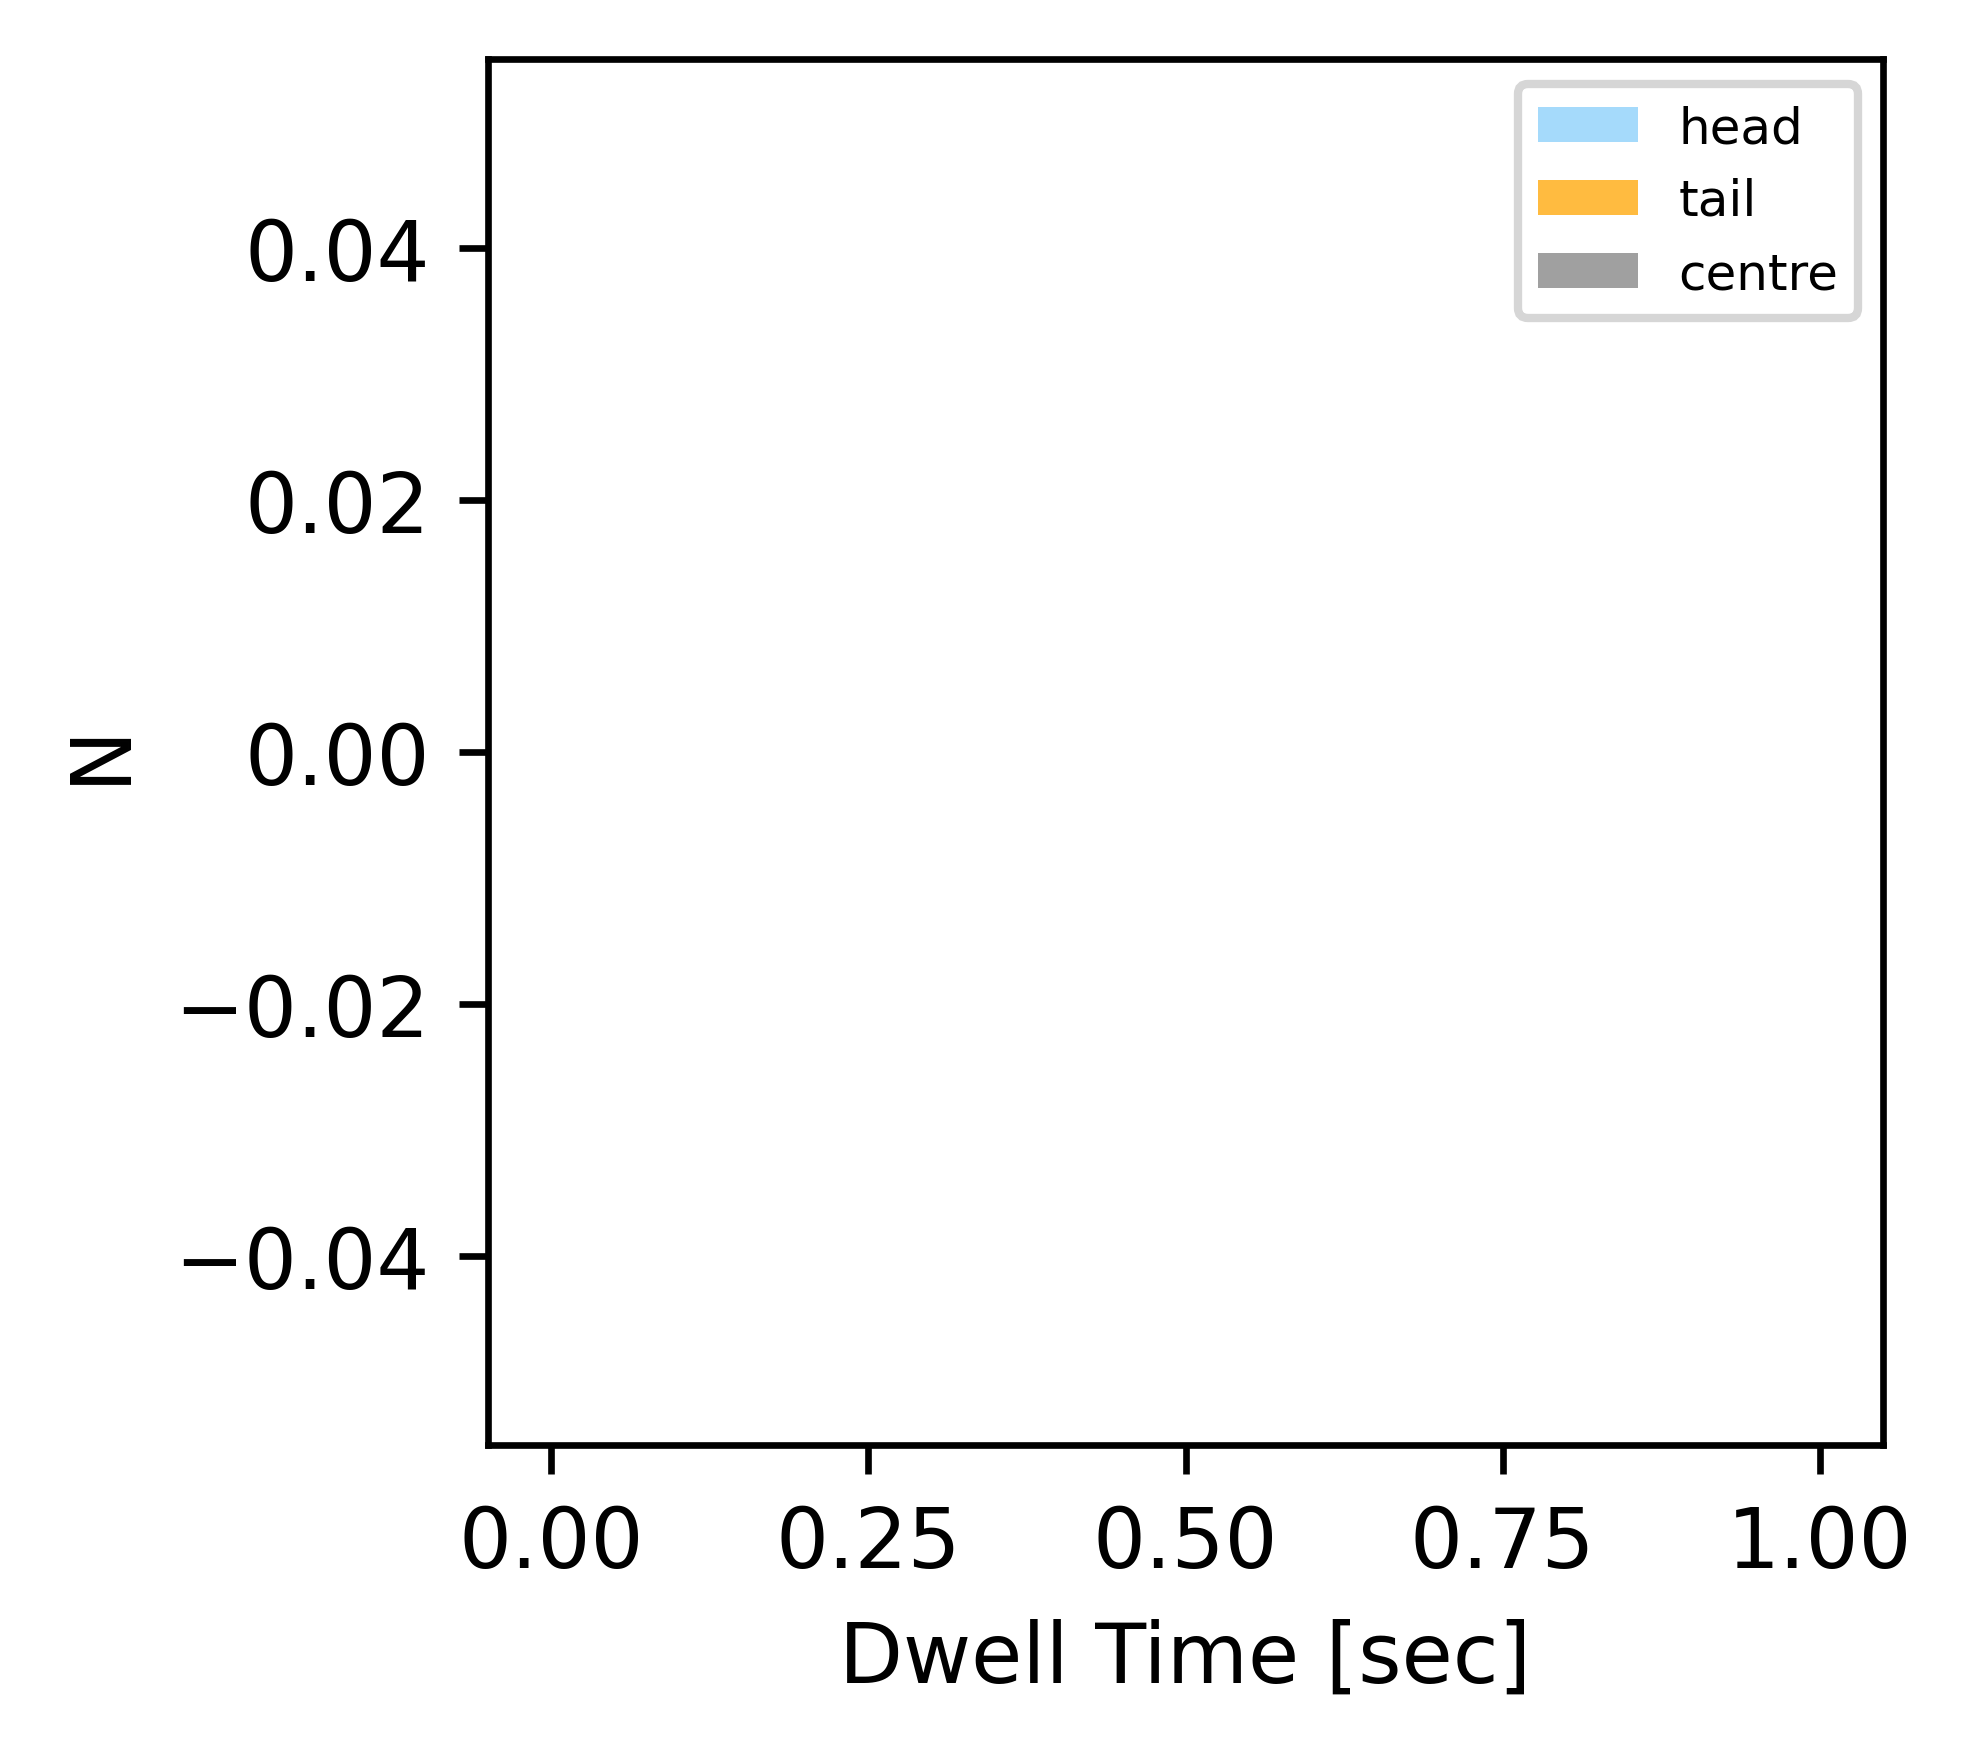

In [15]:

###########
#plot dwell time distrubition
###########

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=600)
ax.hist(stopDurationsHead,bins=20, density=False, alpha=0.75, color='lightskyblue',label='head')
ax.hist(stopDurationsTail,bins=20, density=False, alpha=0.75, color='orange',label='tail')
ax.hist(stopDurationsC,bins=20, density=False, alpha=0.75, color='gray',label='centre')
ax.set_ylabel('N')
ax.set_xlabel('Dwell Time [sec]')
#ax.set_yscale('log')
ax.legend(loc="upper right",fontsize=6)

fig.savefig(saveFile_image2)
plt.show()
plt.close(fig)

###########
#calculate bits of info and store
###########

#mean speed and expected reversal number
D_to_travel = trackLength - filLength
medianSpeed = np.median(speedC_xy)
meanSpeed = np.mean(speedC_xy)
maxSpeed = np.max(speedC_xy)
t_to_travel = D_to_travel / meanSpeed
obsDuration = frame_ids[-1]*dt
NreversalExp = np.round(obsDuration / t_to_travel)

#mean dwell time
meanDwellTime = np.mean(stopDurationsC)
meanDwellTimeA = np.mean(stopDurationsHead)
meanDwellTimeB = np.mean(stopDurationsTail)

In [16]:
###########
#SAVE THE DATA - summary
###########


# Prepare the results table

result_dict = {'FilamentID': base, 'filLength': filLength, 'trackLength': trackLength, 'expectedReversals': NreversalExp, 'nReversals': nReversalsC,  
                      'maxSpeed': maxSpeed,'meanSpeed': meanSpeed,'medianSpeed': medianSpeed, 'meanDwellTime': meanDwellTime, 'meanDwellTime_endA': meanDwellTimeA, 'meanDwellTime_endB': meanDwellTimeB,
                      'sparsityForSplines': sparsity, 'splineOrder': spline_k, 'speedLimitForDwell': speedLimit, 'obsTime': obsDuration}
result = pd.DataFrame.from_dict([result_dict])
result.head()

f = open(saveMyData, 'w')

# ------------------ SAVE ---------------- #
result.to_csv(f, sep='\t')
f.close()


In [17]:
###########
#SAVE THE DATA - dwell distrubiution
###########


# Prepare the results table

result_dict2 = dict(dwellTimeCentre=stopDurationsC*dt,dwellTimeTail=stopDurationsTail*dt,dwellTimeHead=stopDurationsHead*dt)
result2 = pd.DataFrame.from_dict(result_dict2, orient='index')
result2 = result2.transpose()
result2.head()

f2 = open(saveMyData_dwell, 'w')

# ------------------ SAVE ---------------- #
result2.to_csv(f2, sep='\t')
f2.close()

TypeError: can't multiply sequence by non-int of type 'float'